In [1]:
import sys
import os
sys.path.append(os.path.abspath('../')) # Point to project root

In [11]:
import importlib
import modules.trainer
import modules.utils
import modules.callbacks
import modules.env
import env.custom_hopper

# Force reload of the modules you changed
importlib.reload(modules.env)
importlib.reload(modules.callbacks)
importlib.reload(modules.utils)
importlib.reload(modules.trainer)
importlib.reload(env.custom_hopper)

# Re-import the specific functions into the global namespace
from modules.trainer import train_agent
from modules.utils import plot_learning_curve, plot_doraemon_dynamics
from env.custom_hopper import *

print("Modules reloaded successfully!")

Modules reloaded successfully!


In [14]:
from modules.trainer import train_agent
from modules.utils import *
from env.custom_hopper import *

In [3]:
config = {
    'env_id': 'CustomHopper-source-v0',
    'algo': 'sac',
    'seed': 42,
    'timesteps': 1_000_000,
    'vectorize': True,
    'normalize': True, 
    'lr': 1e-3,
    
    # DORAEMON Settings
    'use_doraemon': True,     # This triggers GaussianHopperWrapper + DoraemonCallback

}

In [4]:
# Training
model, env, doraemon_cb = train_agent(config)

Using cpu device
Starting Real DORAEMON training...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.5     |
|    ep_rew_mean     | 9.92     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1060     |
|    time_elapsed    | 0        |
|    total_timesteps | 108      |
| train/             |          |
|    actor_loss      | -2.17    |
|    critic_loss     | 7.17     |
|    ent_coef        | 1        |
|    ent_coef_loss   | 0        |
|    learning_rate   | 0.001    |
|    n_updates       | 1        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.4     |
|    ep_rew_mean     | 11.4     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 728      |
|    time_elapsed    | 0        |
|    total_timesteps | 164      |
| train/             |          |
|    actor_loss      | -4.85  

Found 1 log files: ['monitor.csv']


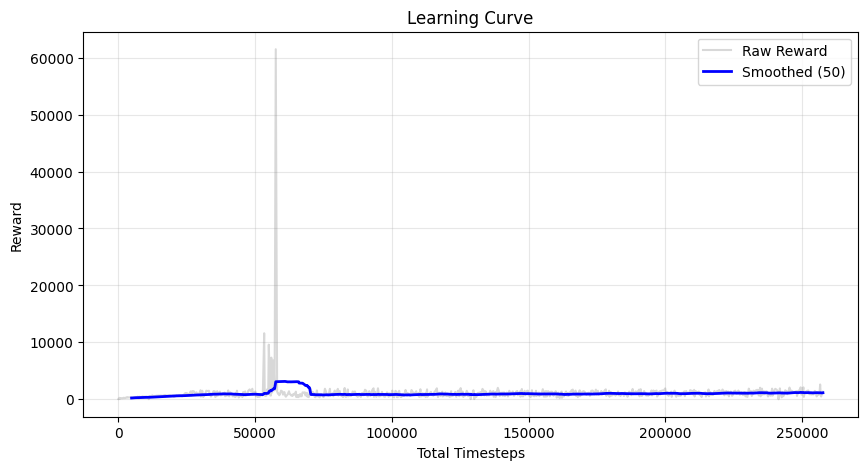

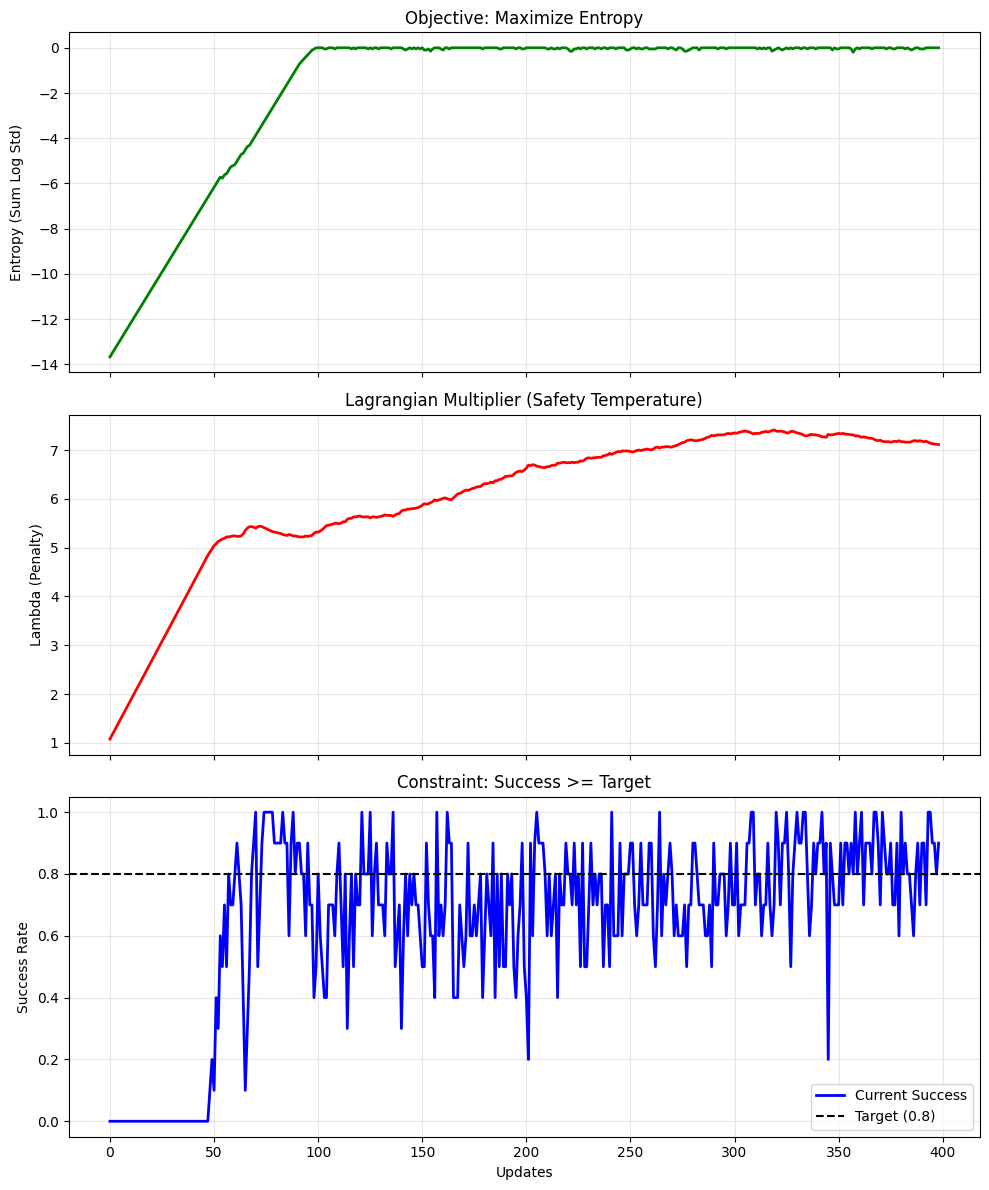

In [12]:
# Plot
plot_learning_curve("./logs/")
plot_doraemon_dynamics(doraemon_cb) # uses the new function from utils.py

In [15]:
# ---------------------------------------------------------
# SIM2REAL EVALUATION
# ---------------------------------------------------------
# Define Source and Target environments for final test
# Note: Target usually a has fixed, shifted mass: Torso +1kg
source_env = gym.make('CustomHopper-source-v0')
target_env = gym.make('CustomHopper-target-v0')

evaluate_sim2real(model, source_env, target_env)

NameError: name 'evaluate_sim2real' is not defined

In [16]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

def evaluate_sim2real(model, source_env_raw, target_env_raw, log_dir, model_name, n_eval_episodes=20):
    """
    Evaluates the model on Source (Training Domain) vs Target (Shifted Domain).
    Crucially, it applies the SAME Normalization stats used during training.
    """
    # 1. Wrap raw envs into Vectorized Envs (required for SB3)
    source_vec = DummyVecEnv([lambda: source_env_raw])
    target_vec = DummyVecEnv([lambda: target_env_raw])

    # 2. Load Normalization Statistics
    # We must use the stats (mean/var) from the TRAINED agent, not new ones!
    norm_path = f"{log_dir}/{model_name}_vecnormalize.pkl"
    
    try:
        # Load the stats and apply them to the new envs
        source_vec = VecNormalize.load(norm_path, source_vec)
        target_vec = VecNormalize.load(norm_path, target_vec)
        
        # IMPORTANT: Turn off training updates and reward normalization for evaluation
        source_vec.training = False
        source_vec.norm_reward = False
        target_vec.training = False
        target_vec.norm_reward = False
        
        print(f"Loaded Normalization stats from {norm_path}")
    except FileNotFoundError:
        print("Warning: No normalization stats found. Evaluating with RAW observations (Expect poor performance).")

    # 3. Evaluate on Source (The "Sim")
    print("\n--- Evaluating on SOURCE Env (Simulation) ---")
    mean_reward, std_reward = evaluate_policy(model, source_vec, n_eval_episodes=n_eval_episodes, deterministic=True)
    print(f"Source Reward: {mean_reward:.2f} +/- {std_reward:.2f}")

    # 4. Evaluate on Target (The "Real")
    print("\n--- Evaluating on TARGET Env (Real/Shifted) ---")
    mean_reward_real, std_reward_real = evaluate_policy(model, target_vec, n_eval_episodes=n_eval_episodes, deterministic=True)
    print(f"Target Reward: {mean_reward_real:.2f} +/- {std_reward_real:.2f}")
    
    return mean_reward, mean_reward_real

# ---------------------------------------------------------
# EXECUTION
# ---------------------------------------------------------
# Define the raw environments
source_env = gym.make('CustomHopper-source-v0')
target_env = gym.make('CustomHopper-target-v0')

# Reconstruct the model name used in training
model_name = f"{config['algo']}_doraemon_{config['seed']}"

# Run evaluation
evaluate_sim2real(model, source_env, target_env, log_dir="./logs/", model_name=model_name)

Loaded Normalization stats from ./logs//sac_doraemon_42_vecnormalize.pkl

--- Evaluating on SOURCE Env (Simulation) ---


/Users/alessandrobenvenuti/miniconda3/envs/RL_lab04/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Source Reward: 991.51 +/- 6.29

--- Evaluating on TARGET Env (Real/Shifted) ---
Target Reward: 1165.21 +/- 308.04


(np.float64(991.5110689103603), np.float64(1165.2116862565279))